In [2]:
### OBTAIN BIDIRECTIONALLY CONNECTED NEURONS ### 
import numpy as np
probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

# get tuples of connected neurons
ai,bi = np.where(abs(probe1_371) != 0)
index_pairs = list(zip(ai,bi))

with open("birirectionally.txt", 'w') as f:
    bidirectionally = []
    for (r,t) in index_pairs:
        if (t,r) in index_pairs and (t,r) not in bidirectionally:
            bidirectionally.append((r,t))
            f.write(str(t) + " " + str(r) + "\n")


In [91]:
### COMPUTE MIN NUMBER OF STATE OCCURRENCES in each BIDIRECTIONALLY CONNECTED pair ### 
from temporal_emergence import TPMMaker 
import numpy as np
folder = "GLMCC/Cori_2016-12-14_probe1"

### OBTAIN BIDIRECTIONALLY CONNECTED NEURONS ### 

probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

# get tuples of connected neurons
ai,bi = np.where(abs(probe1_371) != 0)
index_pairs = list(zip(ai,bi))

bidirectionally = []
for (r,t) in index_pairs:
    if (t,r) in index_pairs and (t,r) not in bidirectionally:
        bidirectionally.append((r,t))

### COMPUTE MIN OCCURRENCES ### 
### PARAMETERS ###

NUM_BITS = 2

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
num_binsizes = 9
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

min_num_occurrences = np.zeros((len(bidirectionally), len(binsizes)))


for p in range(len(bidirectionally)):
    i,j = bidirectionally[p]
    ### LOAD DATASET ###

    i_sec = np.loadtxt(folder + "/cell" + str(i) + ".txt") / 1000   # divide through as they are loaded in seconds
    j_sec = np.loadtxt(folder + "/cell" + str(j) + ".txt") / 1000
    cluster = np.array([i_sec, j_sec])

    ### PARAMETERS ###
    skips = list(range(2,11,2))
    max_binsize = 0.02  # 50 ms bins
    min_binsize = 0.0029 # 1ms bins  -   probably won't work
    num_binsizes = 9
    binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

    ### LOOP THROUGH PARAMETERS, computing min of state occurrences ###
    for k in range(len(binsizes)):
        binsize = binsizes[k]
        min_occ = np.min(TPMMaker.get_num_state_occurrences(cluster,binsize, NUM_BITS, 0))   # keep skip at 0, it's not actually used
        min_num_occurrences[p,k] = min_occ



Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'

/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ra

IndexError: index 9 is out of bounds for axis 1 with size 9

In [93]:
## GET THE PHIS FOR A PARTICULAR NEURON PAIR
import numpy as np
from temporal_emergence import TPMMaker, PhiCalculator
def get_phis(ref, tar, num_transitions, infolder, outfolder):
    ### LOAD DATASET ###

    i_sec = np.loadtxt(infolder + "/cell" + str(ref) + ".txt") / 1000   # divide through as they are loaded in miliseconds
    j_sec = np.loadtxt(infolder + "/cell" + str(tar) + ".txt") / 1000
    cluster = np.array([i_sec, j_sec])

    ### COMPUTE PHIS ###

    NUM_BITS = 2

    max_binsize = 0.02  # 20 ms bins
    min_binsize = 0.001 # skip 1ms bins  -   never work and are very slow to compute
    num_binsizes = 10
    binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)


    micro_phis = np.zeros((len(binsizes), len(skips)))
    macro_phis = np.zeros((len(binsizes), len(skips)))

    for i in range(len(binsizes)):
        binsize = binsizes[i]
        for j in range(len(skips)):
            skip = skips[j]

            try:
                TPM,_ = TPMMaker.TPM_from_spiketrains(cluster,binsize,NUM_BITS,skip,num_transitions)
                tpmname = "micro_" + str(i) + "_" + str(j) + "_occs_" + str(num_transitions) + "_bin_"+str(binsize)+"_skip_"+str(skip)+".csv" 
                np.savetxt(outfolder+"/"+tpmname, TPM)
                success = True
            except:
                success = False
                print("Failed for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            if success:
                micro_phis[i,j] = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
                macro_phis[i,j] = PhiCalculator.get_macro_average_phi(TPM, verbose=False)
                print("Success for binsize: " + str(binsize) + " and skip: " + str(skip))
            
            else:
                micro_phis[i,j] = None
                macro_phis[i,j] = None
    
    micro_phis = np.array(micro_phis, dtype=np.float64)
    macro_phis = np.array(macro_phis, dtype=np.float64)
    
    max_micro = np.nanmax(micro_phis)
    max_macro = np.nanmax(macro_phis)
    macro_win = True if max_macro > max_micro else False

    return macro_win

get_phis(143, 168, 200, "GLMCC/Cori_2016-12-14_probe1", "results")

/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
Failed for binsize: 0.001 and skip: 2
Failed for binsize: 0.001 and skip: 4
Failed for binsize: 0.001 and skip: 6
Failed for binsize: 0.001 and skip: 8
Failed for binsize: 0.001 and skip: 10
Success for binsize: 0.003111111111111111 and skip: 2
Success for binsize: 0.003111111111111111 and skip: 4
Success for binsize: 0.003111111111111111 and skip: 6
Success for binsize: 0.003111111111111111 and skip: 8
Success for binsize: 0.003111111111111111 and skip: 10
Success for binsize: 0.005222222222222222 and skip: 2
Success for binsize: 0.005222222222222222 and skip: 4
Success for binsize: 0.005222222222222222 and skip: 6
Succe

KeyboardInterrupt: 

In [ ]:
### FOR PAIR 143, 168, REPEATEDLY COMPUTE PHIS FOR DIFFERENT NUMBER OF MIN OCCURRENCES,
### TO SEE PROPORTION OF MACRO WINS AT DIFFERENT NUMBERS OF MIN OCCURRENCES

NUM_BITS = 2

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
num_binsizes = 9
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)

occurrences = range(100, 1100, 100)
NUM_REPETITIONS = 100

outfolder = "TPM_143_168_varying_min_occs"

### REPEATEDLY COMPUTE PHIS AND SEE IF MACRO WINS, FOR VARIOUS MIN NUMBER OF REPETITIONS
macro_wins = np.zeros((len(occurrences)))
for i in range(len(occurrences)):
    min_occurrence = occurrences[i]
    for rep in range(NUM_REPETITIONS):
        macro_win = get_phis(min_occurrence, outfolder)
        if macro_win:
            macro_wins[i] += 1

macro_wins_pct = macro_wins / NUM_REPETITIONS


(9, 736)

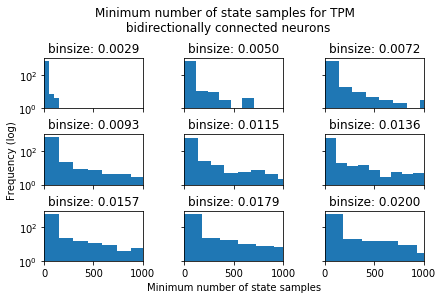

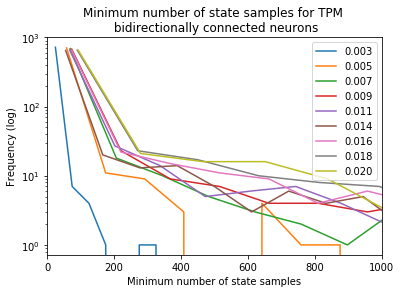

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

minimal_connections = np.load("results/min_occurrences.npy", allow_pickle=True)
minimal_connections = [conn[2] for conn in minimal_connections]

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
binsize = np.linspace(min_binsize, max_binsize, 9)
minimal_connections = np.transpose(minimal_connections)
fig, ax = plt.subplots(3,3)
fig.suptitle('Minimum number of state samples for TPM \n bidirectionally connected neurons')
fig.tight_layout()
plt.grid(False)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Frequency (log)")
plt.xlabel("Minimum number of state samples")

for i in range(3):
    for j in range(3):
        #plt.figure()
        ax[i,j].hist(minimal_connections[i*3 + j], bins = 25)
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim([0, 1000])
        ax[i,j].set_ylim([1, 10**3])
        ax[i,j].set_title("binsize: " + '%.4f' % (binsize[i*3 + j]))
plt.subplots_adjust(top=0.8)

for ax in fig.get_axes():
    ax.label_outer()

plt.figure()
for i in range(minimal_connections.shape[0]):
    h,x = np.histogram(minimal_connections[i], bins=25)
    bin_centers = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers,h, label='%.3f' % (binsize[i]))
    plt.yscale('log')
    plt.xlim([0,1000])
    plt.ylabel("Frequency (log)")
    plt.xlabel("Minimum number of state samples")
    plt.title('Minimum number of state samples for TPM \n bidirectionally connected neurons')
    plt.legend()
minimal_connections.shape